Spectral integration for u'' = cos(x)
 N    max error
---------------------
  8   9.811e-12
 16   1.110e-16
 32   1.665e-16
 64   1.665e-16
128   4.441e-16


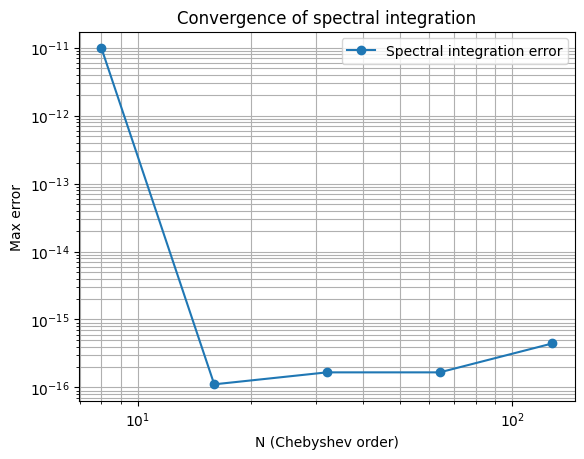

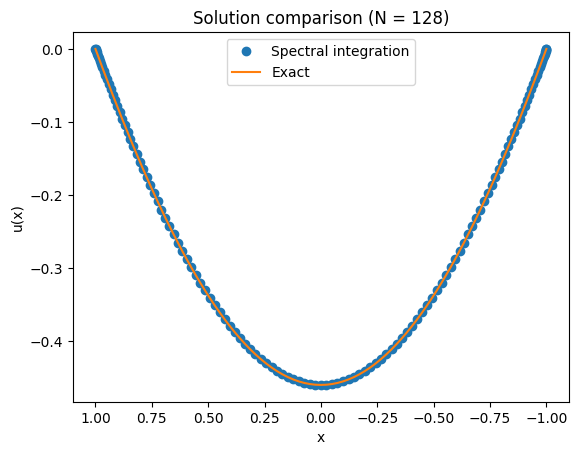

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.chebyshev import chebfit, chebval, chebint

# ------------------------------------------------------------
# Problem setup
#   u''(x) = cos(x),  x in [-1, 1]
#   u(-1) = 0, u(1) = 0
# ------------------------------------------------------------

def exact_solution(x):
    """
    Exact solution of:
        u'' = cos(x)
        u(-1) = u(1) = 0
    """
    # General solution: u = -cos(x) + A x + B
    A = (np.cos(1) - np.cos(-1)) / 2.0
    B = np.cos(1) - A
    return -np.cos(x) + A * x + B


def spectral_integration_solution(N):
    """
    Solve u'' = cos(x) using spectral integration with Chebyshev polynomials.
    Returns:
        x       : Chebyshev–Lobatto points
        u_vals  : numerical solution at x
        u_exact : exact solution at x
        max_err : max error on Chebyshev grid
    """

    # Chebyshev–Lobatto points
    k = np.arange(N + 1)
    x = np.cos(np.pi * k / N)

    # Step 1: define phi = u''
    phi_vals = np.cos(x)

    # Step 2: Chebyshev expansion of phi
    phi_cheb = chebfit(x, phi_vals, N)

    # Step 3: spectral integration once -> u'
    u1_cheb = chebint(phi_cheb)

    # Step 4: spectral integration twice -> u
    u2_cheb = chebint(u1_cheb)

    # Step 5: enforce Dirichlet BC to determine C0, C1
    u_base_left  = chebval(-1.0, u2_cheb)
    u_base_right = chebval( 1.0, u2_cheb)

    alpha = 0.0  # u(-1)
    beta  = 0.0  # u(1)

    C0 = alpha - u_base_left
    C1 = (beta - u_base_right - C0) / 2.0

    # Step 6: construct final solution
    u_vals = chebval(x, u2_cheb) + C1 * (x + 1.0) + C0

    # Exact solution
    u_ex = exact_solution(x)

    # Error
    max_err = np.max(np.abs(u_vals - u_ex))

    return x, u_vals, u_ex, max_err



N_list = [8, 16, 32, 64, 128]
errors = []

print("Spectral integration for u'' = cos(x)")
print(" N    max error")
print("---------------------")

for N in N_list:
    _, _, _, err = spectral_integration_solution(N)
    errors.append(err)
    print(f"{N:3d}   {err:.3e}")

# Plot convergence
plt.figure()
plt.loglog(N_list, errors, "o-", label="Spectral integration error")
plt.xlabel("N (Chebyshev order)")
plt.ylabel("Max error")
plt.title("Convergence of spectral integration")
plt.grid(True, which="both")
plt.legend()
plt.show()

# Plot solution for largest N
N_plot = N_list[-1]
x, u_num, u_ex, _ = spectral_integration_solution(N_plot)

plt.figure()
plt.plot(x, u_num, "o", label="Spectral integration")
plt.plot(x, u_ex, "-", label="Exact")
plt.gca().invert_xaxis()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(f"Solution comparison (N = {N_plot})")
plt.legend()
plt.show()


Condition number comparison
 N     cond(D)          cond(S)
-------------------------------------
  8      2.882e+17      1.270e+02
 16      5.765e+17      5.110e+02
 32      1.153e+18      2.047e+03
 64      1.153e+18      8.191e+03
128      8.385e+17      3.277e+04


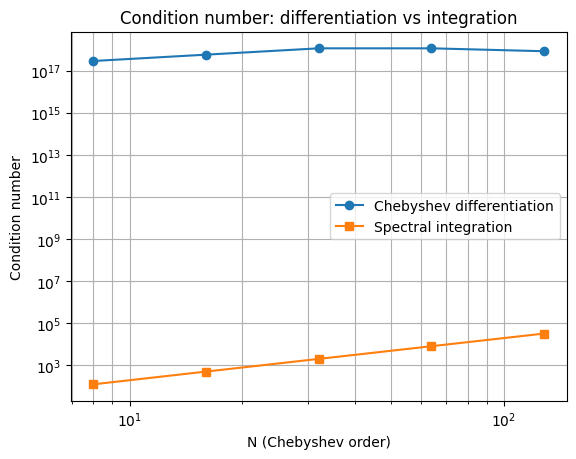

In [18]:
import numpy as np
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# Chebyshev differentiation matrix (1st derivative)
#   on Chebyshev–Lobatto points
#   Reference: Trefethen, Spectral Methods in MATLAB
# ------------------------------------------------------------
def cheb_diff_matrix(N):
    if N == 0:
        return np.array([[0.0]])

    x = np.cos(np.pi * np.arange(N + 1) / N)
    c = np.ones(N + 1)
    c[0] = 2.0
    c[-1] = 2.0
    c = c * (-1) ** np.arange(N + 1)

    X = np.tile(x, (N + 1, 1))
    dX = X - X.T

    D = np.outer(c, 1 / c) / (dX + np.eye(N + 1))
    D = D - np.diag(np.sum(D, axis=1))

    return D


# ------------------------------------------------------------
# Spectral integration matrix
#   Implemented as the inverse of differentiation
#   on the subspace excluding constants
#
#   This mirrors Greengard's idea:
#   integration = bounded inverse of differentiation
# ------------------------------------------------------------
def spectral_integration_matrix(N):
    D = cheb_diff_matrix(N)

    # Remove nullspace (constant mode)
    D_reduced = D[1:, 1:]

    # Pseudoinverse = discrete integration operator
    S = np.linalg.pinv(D_reduced)

    return S


N_list = [8, 16, 32, 64, 128]
cond_diff = []
cond_int = []

print("Condition number comparison")
print(" N     cond(D)          cond(S)")
print("-------------------------------------")

for N in N_list:
    D = cheb_diff_matrix(N)
    S = spectral_integration_matrix(N)

    cD = np.linalg.cond(D, np.inf)
    cS = np.linalg.cond(S, np.inf)

    cond_diff.append(cD)
    cond_int.append(cS)

    print(f"{N:3d}   {cD:12.3e}   {cS:12.3e}")

# --------------------------------------------------------
# Plot
# --------------------------------------------------------
plt.figure()
plt.loglog(N_list, cond_diff, "o-", label="Chebyshev differentiation")
plt.loglog(N_list, cond_int, "s-", label="Spectral integration")

plt.xlabel("N (Chebyshev order)")
plt.ylabel("Condition number")
plt.title("Condition number: differentiation vs integration")
plt.legend()
plt.grid(True, which="both")

plt.show()
